# Evaluation of intended filters

Here we want to find out which filter (Gaussian or Bilateral) works best in comparison to the unfiltered images using the Dice score and the image Otsu_t13.tiff

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree

In [22]:
from Functions.KMeans import split_channels
from Functions.KMeans import init_centroids
from Functions.KMeans import euclidean_distance_3d
from Functions.KMeans import assign_to_centroids_kdtree
from Functions.KMeans import update_centroids
from Functions.KMeans import kmeans_clusteringGrayscale_kdtree
import os

In [23]:
#Normalisiert grayscale
def normalize_grayscale(image):
    """
    Normalisiert ein Graustufenbild auf Werte zwischen 0 und 1 (float).
    """
    image = image.astype(float)
    norm_img = (image - image.min()) / (image.max() - image.min())
    return norm_img

In [24]:
t13_bilateral = np.copy(plt.imread('Images/Datenvorbereitung_images/Otsu/Filtered_t13/t13_bilateral.tiff'))
t13_gauß = np.copy(plt.imread('Images/Datenvorbereitung_images/Otsu/Filtered_t13/t13_gauß.tiff'))
t13 = np.copy(plt.imread('Original_Images/Otsu/Data/N2DL-HeLa/img/t13.tif'))
t13_bilateral_norm = normalize_grayscale(t13_bilateral)
t13_gauß_norm = normalize_grayscale(t13_gauß)
t13_norm = normalize_grayscale(t13)




In [25]:
def init_centroids(features, k, random_seed=None):
    """
    Initialisiert k Zentroiden zufällig aus den Feature-Vektoren.
    """
    np.random.seed(random_seed)
    indices = np.random.choice(features.shape[0], k, replace=False)
    return features[indices]

def euclidean_distance(a, b):
    """
    Berechnet die euklidische Distanz zwischen zwei Arrays a und b.
    a: (n_samples, n_features)
    b: (k, n_features)
    Rückgabe: (n_samples, k)
    """
    return np.linalg.norm(a[:, None] - b[None, :], axis=-1)

def assign_to_centroids(features, centroids):
    """
    Ordnet jedem Feature den nächsten Zentroiden zu.
    """
    dists = euclidean_distance(features, centroids)
    return np.argmin(dists, axis=1)

def update_centroids(features, labels, k):
    """
    Aktualisiert die Zentroiden als Mittelwert der zugeordneten Features.
    """
    new_centroids = []
    for i in range(k):
        cluster_points = features[labels == i]
        if len(cluster_points) > 0:
            new_centroids.append(cluster_points.mean(axis=0))
        else:
            # Falls ein Cluster leer ist, wähle zufällig einen Punkt
            new_centroids.append(features[np.random.choice(features.shape[0])])
    return np.array(new_centroids)

def kmeans_image_segmentation(image, k, max_iterations=100, random_seed=None):
    """
    Segmentiert ein normalisiertes Bild (Grayscale, HSV-1ch oder RGB) mit KMeans.
    """
    img = image.copy()
    h, w = img.shape[:2]
    # Feature-Vektoren erzeugen
    if img.ndim == 2:  # Grayscale oder HSV (1 Kanal)
        features = img.reshape(-1, 1)
    elif img.ndim == 3 and img.shape[2] == 3:  # RGB
        features = img.reshape(-1, 3)
    else:
        raise ValueError("Bildformat nicht unterstützt. Erwartet Graustufen, HSV (1 Kanal) oder RGB (3 Kanäle).")
    
    centroids = init_centroids(features, k, random_seed=random_seed)

    for _ in range(max_iterations):
        labels = assign_to_centroids(features, centroids)
        new_centroids = update_centroids(features, labels, k)
        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids

    label_img = labels.reshape(h, w)
    cmap = plt.cm.get_cmap('tab10', k)
    cluster_colors = cmap(np.arange(k))[:, :3]
    segmented_image = cluster_colors[label_img]


    return segmented_image, label_img

# Beispielaufruf:
# img = np.load('dein_bild.npy')  # Bild muss normalisiert (0-1) sein!
# seg_img, labels = kmeans_image_segmentation(img, k=4, max_iterations=50)
# plt.imshow(seg_img)
# plt.axis('off')
# plt.show()

C:\Users\Jonny\AppData\Local\Temp\ipykernel_30872\1017652681.py:63: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', k)


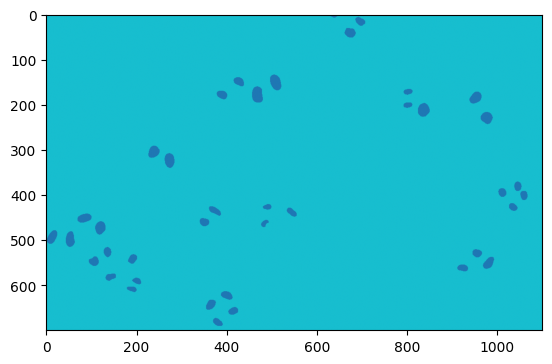

In [26]:
clustered_t13_bilateral_norm = kmeans_image_segmentation(t13_bilateral_norm, k=2, max_iterations=100)
plt.imshow(clustered_t13_bilateral_norm[0])
clustered_t13_gauß_norm = kmeans_image_segmentation(t13_gauß_norm, k=2, max_iterations=100)
clustered_t13_norm = kmeans_image_segmentation(t13_norm, k=2, max_iterations=100)

In [27]:
def save_image(image, path):
    """
    Speichert ein Bild (numpy array) im angegebenen Pfad.
    """
    # Erstelle den Ordner, falls er nicht existiert
    os.makedirs(os.path.dirname(path), exist_ok=True)
    plt.imsave(path, image)

In [ ]:
#save_image(clustered_t13_bilateral_norm[0], 'Images/Segmented_Images/clustered_t13_bilateral_norm.png')
#save_image(clustered_t13_gauß_norm[0], 'Images/Segmented_Images/clustered_t13_gauß_norm.png')
#save_image(clustered_t13_norm[0], 'Images/Segmented_Images/clustered_t13_norm.png')